This script provides a simulation to the Stommel model (1961):

$$
\frac{dx}{d\tau} = \delta (1-x) - \frac{x}{\lambda } |Rx-y|
$$

$$
\frac{dy}{d\tau } = 1-y-\frac{y}{\lambda} |Rx-y|
$$
where $x$ and $y$ are nonnegative, and $R$, $\delta$ and $\lambda$ all constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import cmath

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'font.size': 16})

The following cell defines the time derivatives of Stommel model, where $l$ is the parameter $\lambda$ in the original model as $\lambda$ is already defined in python...

In [2]:
def Stommel(Y,t,R,l,delta):
    
    x, y = Y
    return [delta*(1-x) - x*np.abs(R*x - y)/l, 1-y-y*np.abs(R*x-y)/l]

This cell defines functions for nonlinear root finding, which finds all the roots in a specified range:

In [3]:
# Root finding functions
import math

def rootsearch(f,a,b,dx):
    x1 = a; f1 = f(a)
    x2 = a + dx; f2 = f(x2)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    return x1,x2

def bisect(f,x1,x2,switch=0,epsilon=1e-6):
    f1 = f(x1)
    if f1 == 0.0:
        return x1
    f2 = f(x2)
    if f2 == 0.0:
        return x2
    if f1*f2 > 0.0:
        print('Root is not bracketed')
        return None
    n = int(math.ceil(math.log(abs(x2 - x1)/epsilon)/math.log(2.0)))
    for i in range(n):
        x3 = 0.5*(x1 + x2); f3 = f(x3)
        if (switch == 1) and (abs(f3) >abs(f1)) and (abs(f3) > abs(f2)):
            return None
        if f3 == 0.0:
            return x3
        if f2*f3 < 0.0:
            x1 = x3
            f1 = f3
        else:
            x2 =x3
            f2 = f3
    return (x1 + x2)/2.0

def roots(f, a, b, eps=1e-6):
    ans = []
    print ('The roots on the interval [%f, %f] are:' % (a,b))
    while 1:
        x1,x2 = rootsearch(f,a,b,eps)
        if x1 != None:
            a = x2
            root = bisect(f,x1,x2,1)
            if root != None:
                pass
                print (round(root,-int(math.log(eps, 10))))
                ans = ans + [root]
        else:
            print ('\nDone!')
            break
    return ans

Then for a set of parameters, we seek for all the fixed points. According to the equations above figure 6 in paper, if we define $\lambda f = Rx-y$, then the new parametric equations are:
$$x = \frac{1}{1+|f|/\delta},\quad y = \frac{1}{1+|f|},$$
and $\lambda f$ satisfies:
$$
\lambda f = \phi(f; R,\delta) = Rx-y = -\frac{1}{1+|f|} + \frac{1}{1+|f|/\delta}.
$$
The next cell looks for such $f$ (this part is slow...wait until you see all the values in the output) and then use the value to get $x$ and $y$:

In [4]:
#R = 2; l = 1/5; delta = 1 # 1 fixed point, try it!
R = 2; l = 1/5; delta = 1/6 # 3 fixed points
def phi(f):
    global R
    global l
    global delta
  
    return l*f - ( -1/(1+np.abs(f) ) + R/(1+np.abs(f)/delta))
fzeros = roots(phi, -2,2)
xfp = 1./(1+np.abs(fzeros)/delta)
yfp = 1./(1+np.abs(fzeros))

The roots on the interval [-2.000000, 2.000000] are:
-1.06791
-0.30703
0.21909

Done!


This cell reproduces figure 6 in Stommel paper, which shows the intersections of $\lambda f$ and $\phi (f; R,\delta)$. Red star indicates the fixed points we found numerically.

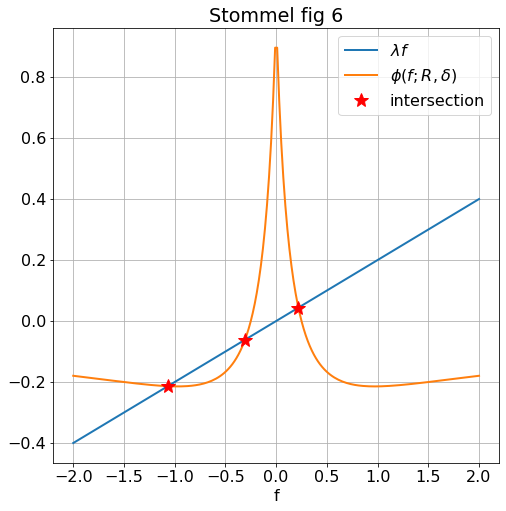

In [5]:
fspan = np.linspace(-2,2,200)
f1 = l*fspan
f2 = f1 - phi(fspan)
plt.plot(fspan,f1,label = r'$\lambda f$')
plt.plot(fspan,f2,label = r'$\phi (f; R,\delta)$')
plt.plot(fzeros,l*np.asarray(fzeros),'r*',markersize=15, label='intersection')
plt.xlabel('f')
plt.title('Stommel fig 6')
plt.grid()
plt.legend()
plt.show()

Now we can plot the phase portrait by simulating some trajectories with different initial conditions (see fig 7/8 in Stommel's paper):

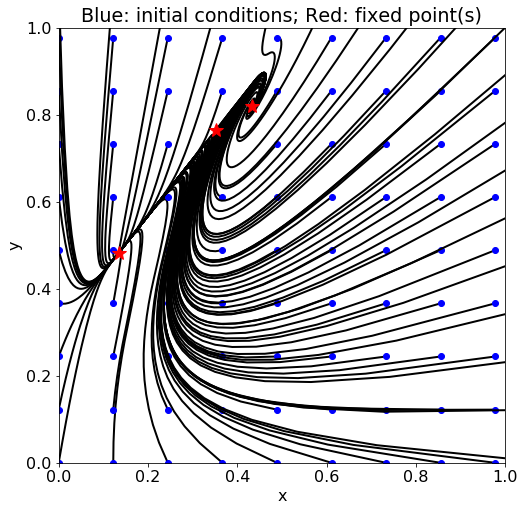

In [6]:
# Plot some trajectories...

args = (R,l,delta)
tspan = np.linspace(0,10,200)
for xs in np.linspace(0.0,1.1,10):
    for ys in np.linspace(0.0,1.1,10):
        
        y = scipy.integrate.odeint(Stommel, np.array([xs,ys]), tspan, args=args)
        plt.plot(*y.transpose(),'k')
        plt.plot(xs,ys,'bo',markersize=6) # initial condition
        
plt.plot(xfp,yfp,'r*',markersize=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Blue: initial conditions; Red: fixed point(s)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The stability can be observed according to the trajectories. Quantitatively, one can also try linearization using Jacobian matrix for each fixed point:

In [7]:
# Jacobian after linearization

def F(x,a,delta):
    return delta*(1-x) - x*np.abs(a);
def G(y,a):
    return 1-y-y*np.abs(a);

# Jacobian, and its trace and determinant 
def Fx(x,a,R,l,delta):
    return -delta - np.abs(a) - R*x*a/(l*np.abs(a))

def Fy(x,a,l):
    return x*a/(l*np.abs(a));

def Gx(y,a,R,l):
    return -R*y*a/(l*np.abs(a));

def Gy(y,a,R,l):
    return -1 - np.abs(a) + y*a/(l*np.abs(a));


def  traceJ(x,y,a,R,l,delta):
    return Fx(x,a,R,l,delta) + Gy(y,a,R,l);
def  detJ(x,y,a,R,l,delta):
    return Fx(x,a,R,l,delta)*Gy(y,a,R,l)-Fy(x,a,l)*Gx(y,a,R,l);
def eigsJ(x,y,a,R,l,delta):
    tr = traceJ(x,y,a,R,l,delta)
    det = detJ(x,y,a,R,l,delta)
    eig1 = 1/2*(tr + cmath.sqrt(tr**2 - 4*det))
    eig2 = 1/2*(tr - cmath.sqrt(tr**2 - 4*det))
    return eig1, eig2, tr, det


for i in range(0,xfp.shape[0]):
    eig1, eig2, tr, det = eigsJ(xfp[i],yfp[i],fzeros[i],R,l,delta)
    print('Fixed point: {}'.format([xfp[i],yfp[i]]))
    print('Tr(J): {}'.format(tr))
    print('Det(J): {}'.format(det))
    print('Eigenvalues: {}, {}'.format(eig1,eig2))

    print('\n')
    

Fixed point: [0.13499909617266623, 0.4835801566572034]
Tr(J): -4.370395488379382
Det(J): 2.7464153295995852
Eigenvalues: (-0.7608825221927733+0j), (-3.6095129661866086+0j)


Fixed point: [0.35184519931706226, 0.7650954283972883]
Tr(J): -2.0877448156285894
Det(J): -2.1674780907985536
Eigenvalues: (0.7608845549356946+0j), (-2.848629370564284+0j)


Fixed point: [0.43205101321027045, 0.8202838141481518]
Tr(J): -1.823938227880312
Det(J): 4.155213498228953
Eigenvalues: (-0.911969113940156+1.82305398533564j), (-0.911969113940156-1.82305398533564j)


